# Experiments

This notebook can be used to a) train different models via adversarial training and report the results; and b) evaluate different (vanilla or adversarial trained models) for different attacks and also document the results.

#### Preamble

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import torch
import time
import pytorch_lightning as pl
from pytorch_lightning import loggers
import config
from utils.Visual import draw_plot, notify


from utils.TrainHelper import TrainHelper, get_all_models_data
from attacks.pgd import ProjectedGradientDescent, PGD_Real
from classification.models.M5 import M5PLModule
from classification.models.SpectrogramCNN import SpectrogramCNNPLModule
from classification.models.CRNN import CRNNPLModule
from classification.models.CRNN_8k import CRNN8kPLModule
from classification.models.SpectrogramCNN_8K import SpectrogramCNN_8KPLModule

/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# Adversarial Training

In [6]:
##############################################################################################################
##############################################################################################################
##############################################################################################################
from utils.TrainHelper import TrainHelper, get_all_models_data
from attacks.pgd import ProjectedGradientDescent
from classification.models.M5 import M5PLModule
#from classification.models.SpectrogramCNN import SpectrogramCNNPLModule
from classification.models.CRNN import CRNNPLModule
from classification.models.CRNN_8k import CRNN8kPLModule
from classification.models.SpectrogramCNN_8K import SpectrogramCNN_8KPLModule



# define hyperparameters
hparams = {
    "batch_size": 64,
    "learning_rate": 9e-4,
    "weight_decay": 1e-3,
    "lr_decay": 0.95,
    "epochs": 1, # just for demo!
    "p_dropout": 0.36,
    "n_hidden": 10,
    "lstm_hidden_size": 64
}

# define attack configs
attack_configs = attack_configs = [
    
                 {"ATTACK_CLASS": ProjectedGradientDescent, 
                   "ATTACK_ARGS": {'norm': ['inf'], 'epsilon': [0.1], 'num_iter': [1]},
                   "META": {"TITLE": "FGSM_eps=0.1_iters=1"}
                   },
    
                 {"ATTACK_CLASS": ProjectedGradientDescent, 
                   "ATTACK_ARGS": {'norm': ['inf'], 'epsilon': [{"SAMPLING_MODE": "choice", "options": [2000]}], 'num_iter': [1]},
                   "META": {"TITLE": "FGSM_eps=0.1_iters=1"}
                   },
]

th = TrainHelper()
th.run(CRNN8kPLModule, hparams, attack_configs, save_epochs = [10,20,30,40, 50])
##############################################################################################################
##############################################################################################################
##############################################################################################################

Trained Models:
['/nfs/students/summer-term-2020/project-4/SAVED_MODELS/CRNN8k/v_34_CRNN8k_attack_FGSM_eps=0.1_iters=1.p', '/nfs/students/summer-term-2020/project-4/SAVED_MODELS/CRNN8k/v_35_CRNN8k_attack_FGSM_eps=0.1_iters=1.p']


['/nfs/students/summer-term-2020/project-4/SAVED_MODELS/CRNN8k/v_34_CRNN8k_attack_FGSM_eps=0.1_iters=1.p',
 '/nfs/students/summer-term-2020/project-4/SAVED_MODELS/CRNN8k/v_35_CRNN8k_attack_FGSM_eps=0.1_iters=1.p']

# Robustness Comparison

Here you can define different attack configurations for which you can evaluate models.

In [5]:
#### ##############################################################################################################
##############################################################################################################

from utils.RobustnessExperiment import RobustnessExperiment, load_experiment
from attacks.FGA_Batch import fast_gradient_attack
from attacks.pgd import ProjectedGradientDescent, PGD_Real
from classification.models.M5 import M5PLModule
from classification.models.SpectrogramCNN_8K import SpectrogramCNN_8KPLModule


from classification.models.CRNN import CRNNPLModule

exp_config = [{
              "attack_fn": PGD_Real, 
              "attack_arg": {"norm":["inf"], "epsilon": [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1], "num_iter":[1]},
              "meta": {"key_result":"acc", "key_config":"epsilon", "title":"FGSM"}
             },

            {
              "attack_fn": PGD_Real, 
              "attack_arg": {"norm":["inf"], "epsilon": [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1], "num_iter":[2]},
              "meta": {"key_result":"acc", "key_config":"epsilon", "title":"FGSM (2 iters)"}
             },

            {
              "attack_fn": PGD_Real, 
              "attack_arg": {"norm":["1"], "epsilon": [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], "num_iter":[1]},
              "meta": {"key_result":"acc", "key_config":"epsilon", "title":"FGA L1"}
             },

            {
              "attack_fn": PGD_Real, 
              "attack_arg": {"norm":["1"], "epsilon": [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], "num_iter":[2]},
              "meta": {"key_result":"acc", "key_config":"epsilon", "title":"FGA L1 (2 iters)"}
             },

            {
              "attack_fn": PGD_Real, 
              "attack_arg": {"norm":["2"], "epsilon": [0, 1, 2, 5, 10, 20, 50, 100, 200, 500], "num_iter":[1]},
              "meta": {"key_result":"acc", "key_config":"epsilon", "title":"FGA L2"}
             },

            {
              "attack_fn": PGD_Real, 
              "attack_arg": {"norm":["2"], "epsilon": [0, 1, 2, 5, 10, 20, 50, 100, 200, 500], "num_iter":[2]},
              "meta": {"key_result":"acc", "key_config":"epsilon", "title":"FGA L2 (2 iters)"}
             }]

# uncomment this if you want to create a new experiment instead!
#experiment = RobustnessExperiment(exp_config, title="ALL_NORMS_REAL")
experiment = load_experiment(exp_folder = "0022_EVAL_EASY_FINAL")
##############################################################################################################
##############################################################################################################
##############################################################################################################

Loaded model 0022_EVAL_EASY_FINAL


Loading cached training data of dataset 0 from /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_8k/
Loading cached validation data of dataset 0 from /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_8k/


  0%|          | 0/11 [00:00<?, ?it/s]



Running experiment on model v_34_CRNN8k_attack_FGSM_eps=0.1_iters=1.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0030_ALL_NORMS/v_34_CRNN8k_attack_FGSM_eps=0.1_iters=1.p'

Perform Attack #1/6: FGSM


100%|██████████| 11/11 [00:41<00:00,  3.79s/it]


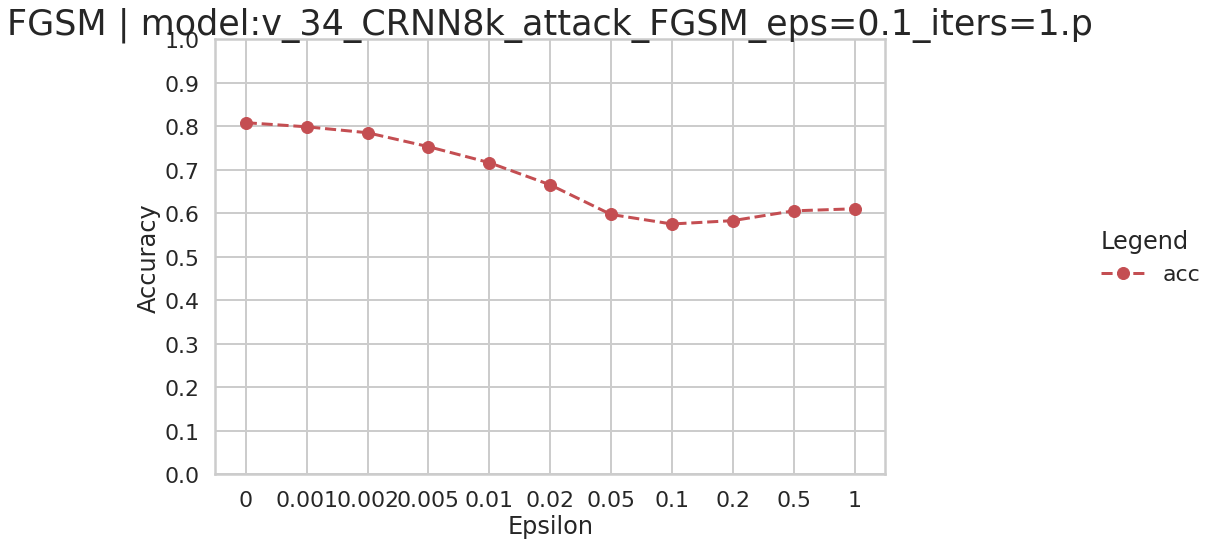

  0%|          | 0/11 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0030_ALL_NORMS/backup.pickle"

Perform Attack #2/6: FGSM (2 iters)


100%|██████████| 11/11 [00:36<00:00,  3.34s/it]


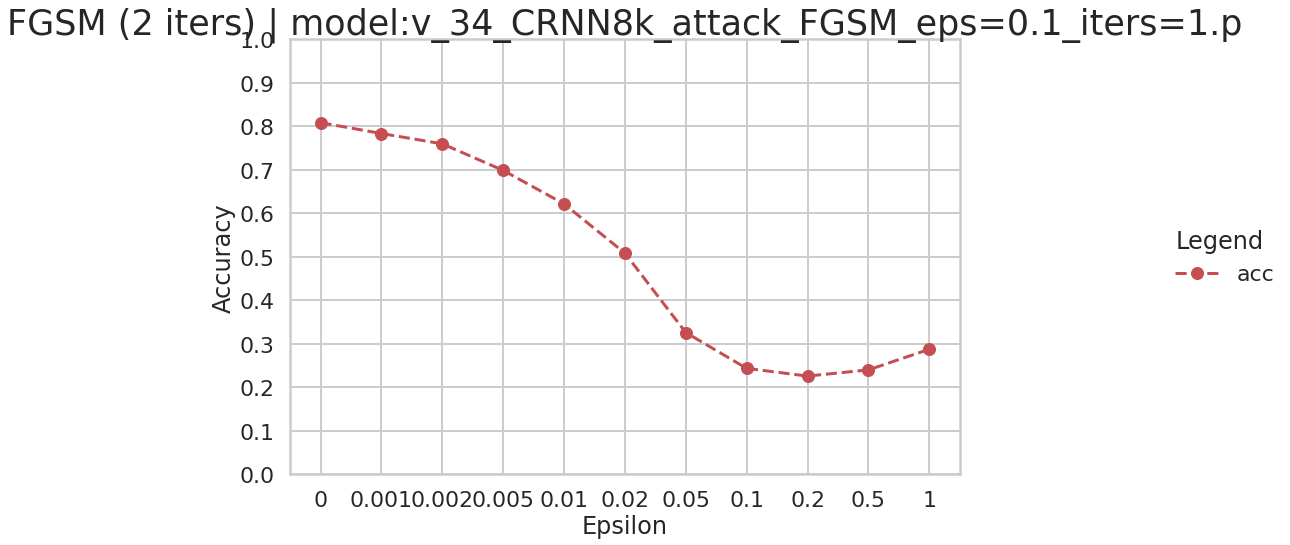

  0%|          | 0/11 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0030_ALL_NORMS/backup.pickle"

Perform Attack #3/6: FGA L1


100%|██████████| 11/11 [00:29<00:00,  2.64s/it]


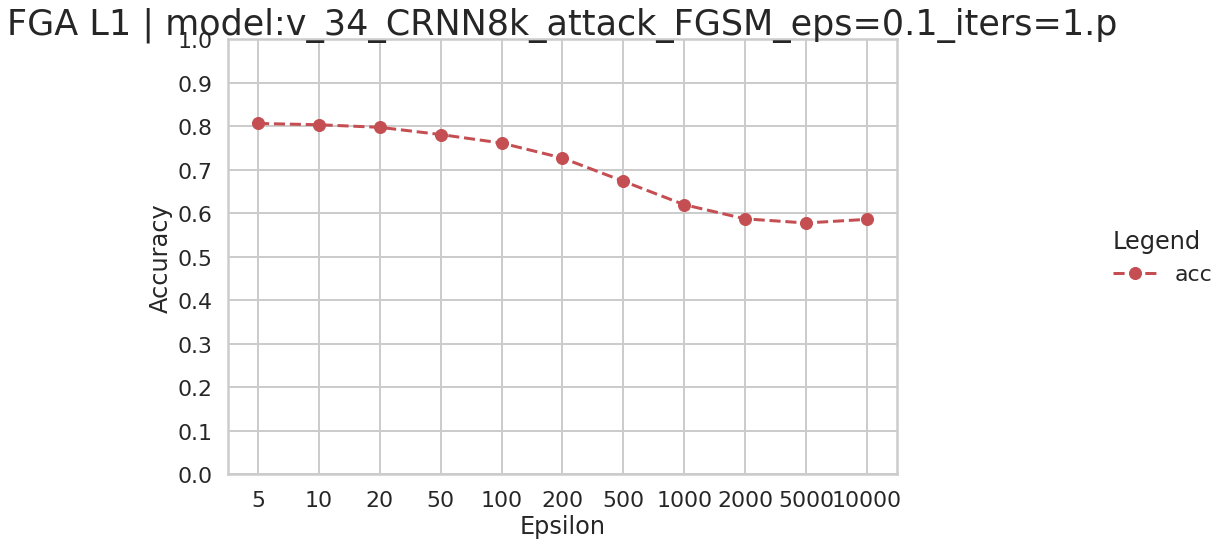

  0%|          | 0/11 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0030_ALL_NORMS/backup.pickle"

Perform Attack #4/6: FGA L1 (2 iters)


100%|██████████| 11/11 [00:38<00:00,  3.54s/it]


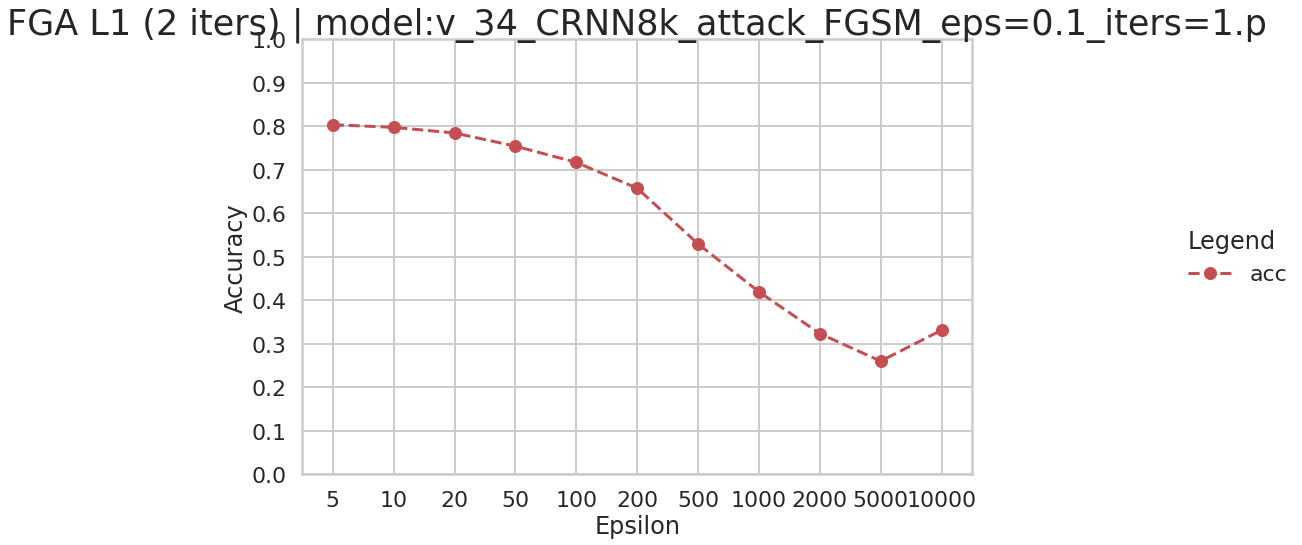

  0%|          | 0/11 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0030_ALL_NORMS/backup.pickle"

Perform Attack #5/6: FGA L2


100%|██████████| 11/11 [00:28<00:00,  2.56s/it]


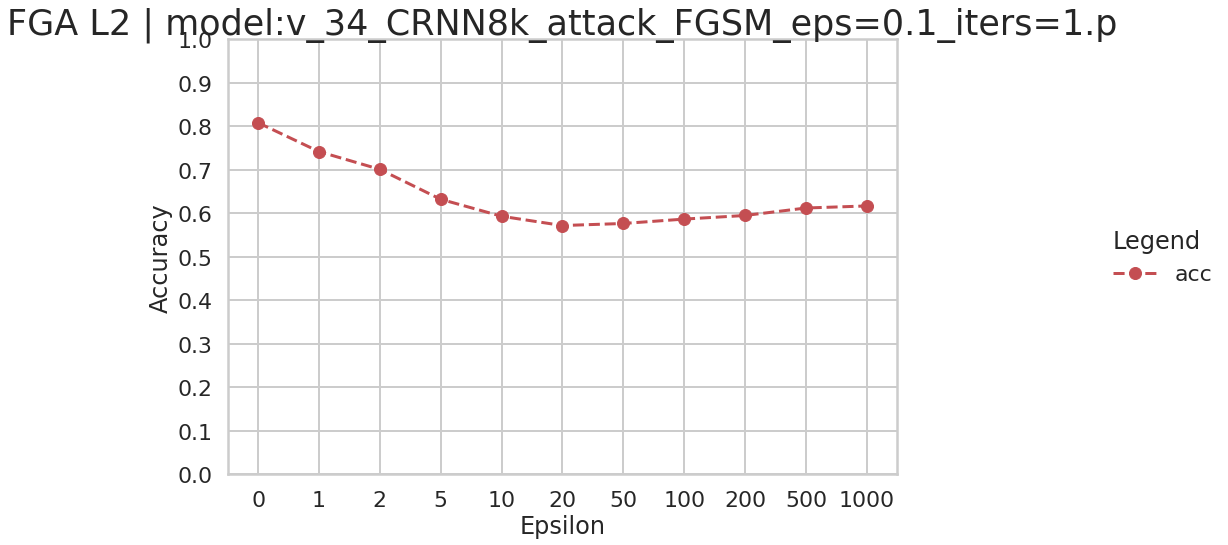

  0%|          | 0/11 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0030_ALL_NORMS/backup.pickle"

Perform Attack #6/6: FGA L2 (2 iters)


100%|██████████| 11/11 [00:37<00:00,  3.40s/it]


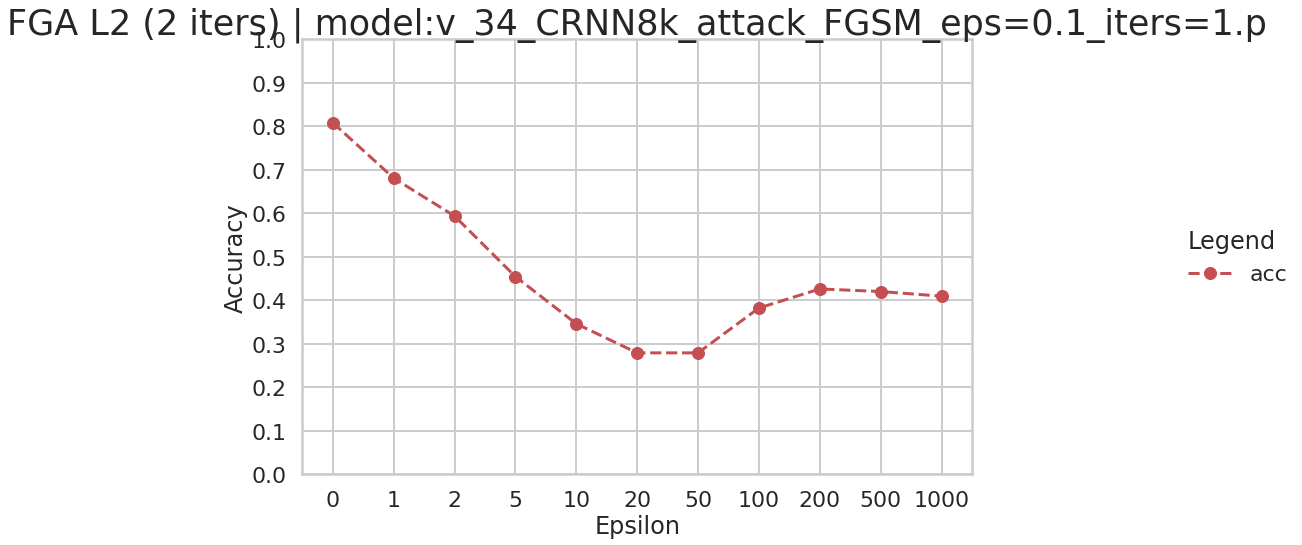

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0030_ALL_NORMS/backup.pickle"


In [10]:
experiment.run("/nfs/students/summer-term-2020/project-4/SAVED_MODELS/CRNN8k/v_34_CRNN8k_attack_FGSM_eps=0.1_iters=1.p", CRNN8kPLModule)

# Plots Results

In [12]:
experiment.show_evaluated_models()

['v_17_CRNN8k_attack_L_1_eps=choice_[500]_iters=1.p',
 'v_18_CRNN8k_attack_L_1_eps=choice_[2000]_iters=1.p',
 'v_19_CRNN8k_attack_L_1_eps=choice_[500, 2000]_iters=1.p',
 'v_109_SpectrogramCNN_8K_attack_L_1_eps=choice_[500]_iters=1.p',
 'M5_vanilla.p',
 'v_25_CRNN8k_attack_REAL REAL L_1_eps=choice_[500]_iters=1.p',
 'v_111_SpectrogramCNN_8K_attack_REAL L_1_eps=choice_[500]_iters=1.p',
 'v_112_SpectrogramCNN_8K_attack_REAL L_1_eps=choice_[2000]_iters=1.p',
 'v_113_SpectrogramCNN_8K_attack_REAL L_1_eps=choice_[500, 2000]_iters=1.p',
 'v_114_SpectrogramCNN_8K_attack_REAL L_1_eps=choice_[500, 2000]_iters=2.p',
 'v_115_SpectrogramCNN_8K_attack_REAL L_2_eps=choice_[500]_iters=21.p',
 'v_116_SpectrogramCNN_8K_attack_REAL L_2_eps=choice_[2000]_iters=1.p',
 'v_117_SpectrogramCNN_8K_attack_REAL L_2_eps=choice_[500, 2000]_iters=1.p',
 'v_118_SpectrogramCNN_8K_attack_REAL L_2_eps=choice_[500, 2000]_iters=2.p',
 'v_119_SpectrogramCNN_8K_attack_REAL L_inf_eps=.1_iters=1.p',
 'v_120_SpectrogramCNN_8K_

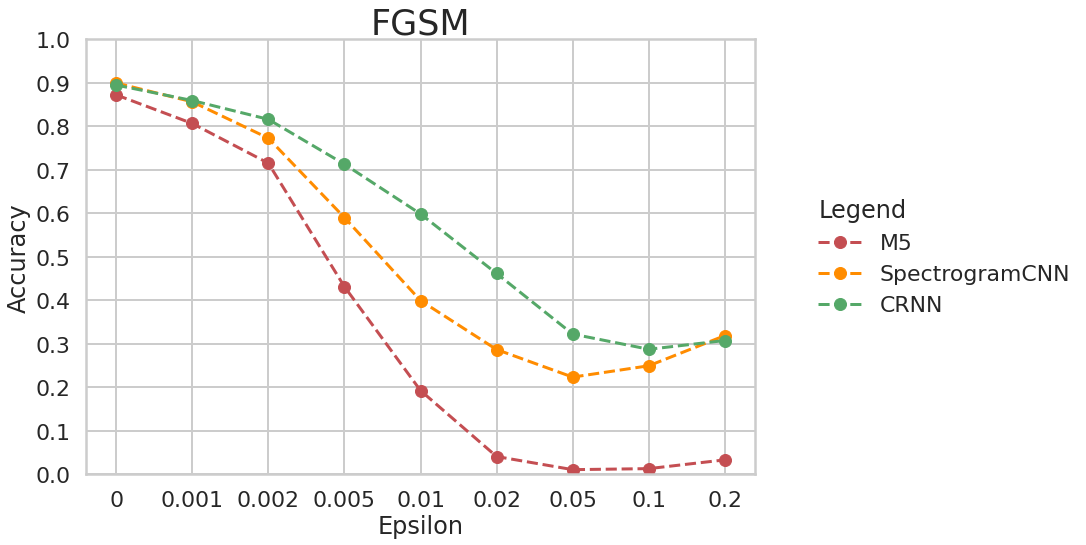

In [6]:
experiment.compare(config_key = "epsilon", results_key = "acc", 
                   models=[
                       ('M5_vanilla.p', "M5"),
                       ('SpectrogramCNN_8k_vanilla_0.8998.p', "SpectrogramCNN"),
                       ('CRNN8k_vanilla_0.8951.p', "CRNN"),
                       ])

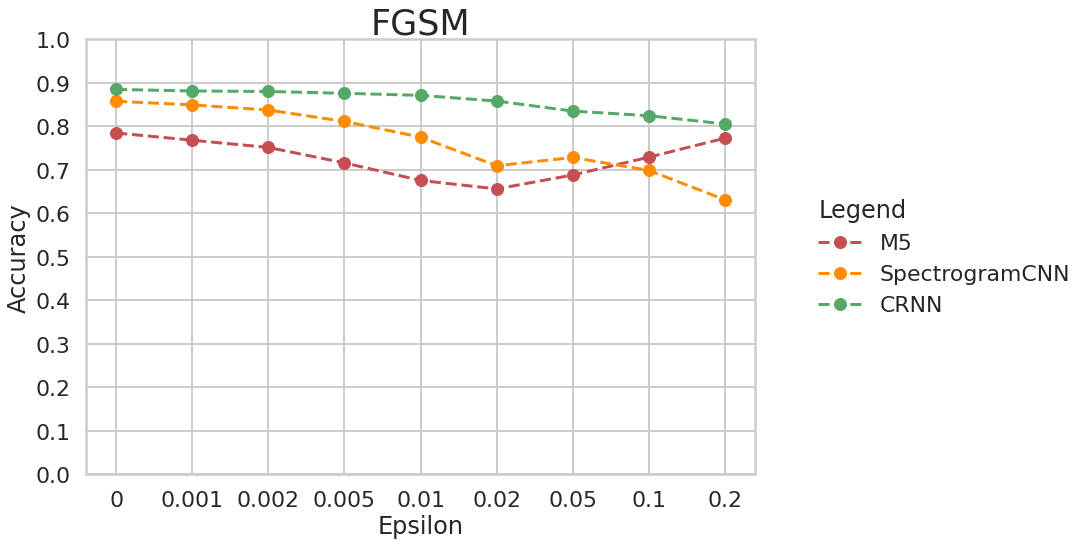

In [7]:
experiment.compare(config_key = "epsilon", results_key = "acc", 
                   models=[
                       ('M5_attack_L_inf, eps=sample_u_0.01_0.3_v150.p', "M5"),
                       ('SpectrogramCNN_8K_attack_L_inf_eps=0.1_iters=1_v6.p', "SpectrogramCNN"),
                       ('CRNN8k_attack_L_inf_eps=0.03_iters=2_v11.p', "CRNN"),
                       ])